# Temporal lda2vec Model

We will implement both the lda2vec-TM model as well as a RNN to predict future document embeddings.

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import numpy as np
import pickle
import pandas as pd
import keras
import matplotlib.pyplot as plt

Found GPU at: /device:GPU:0Metal device set to: Apple M1



2021-11-29 22:11:46.427739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-29 22:11:46.427853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Retrieve Embeddings

We will retrieve back the embeddings and dictionary.

In [3]:
def load_embed():
    doc_embed   = tf.constant(np.load(f"doc_embed_col.npy"))
    word_embed  = tf.constant(np.load(f"word_embed_col.npy"))
    topic_embed = tf.constant(np.load(f"topic_embed_col.npy"))
    return (doc_embed, word_embed, topic_embed)

In [4]:
def load_word_dict(idx_to_word):
    if idx_to_word:
        file = open(f"doc_collect/idx_to_word.pickle", "rb")
        word_dict = pickle.load(file)
    else:
        file = open(f"doc_collect/word_to_idx.pickle", "rb")
        word_dict = pickle.load(file)
    return word_dict

In [5]:
def word_embed_lookup(word):
    word_embed = load_embed()[1]
    word_dict  = load_word_dict(False)
    word_ind   = word_dict[word]
    return word_embed[word_ind]

In [6]:
def word_idx_lookup(word):
    word_dict = load_word_dict(False)
    return word_dict[word]

## Topic Covariance Heatmap
We will plot the topic covariance heatmap.

2021-11-29 22:11:46.987235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-29 22:11:46.987253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


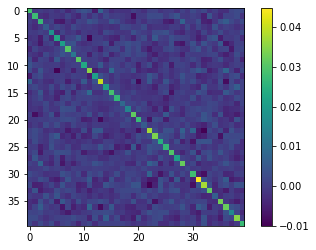

In [7]:
topic_embed = load_embed()[2]
topic_embed = topic_embed/tf.expand_dims(tf.linalg.norm(topic_embed),0)
topic_embed = topic_embed.numpy()
plt.imshow(np.dot(topic_embed, topic_embed.T))
plt.colorbar()

## Modeling Topic Distribution

We now model the topic distribution as a linear model to predict future documents.

In [8]:
def topic_dist():
    embeds = load_embed()
    doc_embed = embeds[0]
    topic_embed = embeds[2]
    norm_doc = tf.nn.softmax(doc_embed)
    topic_dist = tf.linalg.matmul(norm_doc, topic_embed)
    return topic_dist

## Linear Topic Regression
We will model the topic distribution over time as a linear model to predict future documents

In [9]:
# Get transition matrix for training set
def transition():
    dist = topic_dist()[:240]
    old_embed = dist[:239]
    new_embed = dist[1:]
    rhs = tf.linalg.matmul(tf.transpose(old_embed), old_embed)
    lhs = tf.linalg.matmul(tf.transpose(old_embed), new_embed)
    return tf.linalg.lstsq(lhs, rhs, l2_regularizer=0.1)

In [10]:
# Test transition on testing set
test = topic_dist()[240:]
input_embed = test[:59]
out_embed = test[1:60].numpy()
pred = tf.linalg.matmul(input_embed, transition()).numpy()
print("Mean square error:", np.mean((pred - out_embed)**2))
norm_pred = pred/np.reshape(np.linalg.norm(pred,axis=1), (59,1))
norm_out = out_embed/np.reshape(np.linalg.norm(out_embed,axis=1), (59,1))
cosine = 0
for i in range(59):
    cosine += np.dot(norm_pred[i], norm_out[i].T)
print("Average cosine similarity:", cosine/59)

Mean square error: 0.609071
Average cosine similarity: 0.13105160689328688


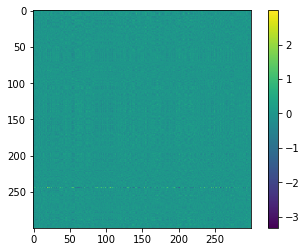

In [11]:
plt.imshow(transition())
plt.colorbar()

## Neural Network Regression

We will implement a recurrent neural network to obtain document vectors.

In [12]:
# convert into dataset matrix
def convertToMatrix(data, step):
    X, Y = [], []
    for i in range(data.shape[0]-step):
        d = i+step
        X.append(data[i:d])
        Y.append(data[d])
    return tf.convert_to_tensor(X), tf.convert_to_tensor(Y)

In [13]:
dist = topic_dist()
idxs_train = list(range(0))+list(range(60,300))
idxs_test = list(range(60))
train = tf.gather(dist, idxs_train)
test = tf.gather(dist, idxs_test)
step = 10

In [14]:
trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)

In [15]:
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Input(shape=(step,300)))
#model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(300, return_sequences=True)))
model.add(tf.keras.layers.GRU(300, input_shape=(step,300), return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(units=300))
#model.add(tf.keras.layers.Dense(300, activation="tanh"))
model.add(tf.keras.layers.Dense(300))
model.compile(loss='cosine_similarity', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 10, 300)           541800    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 300)               180300    
_________________________________________________________________
dense (Dense)                (None, 300)               90300     
Total params: 812,400
Trainable params: 812,400
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(trainX,trainY, epochs=15, batch_size=20, validation_split=0.1)

Epoch 1/15


2021-11-29 22:11:48.552838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-29 22:11:48.553019: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - 2s 107ms/step - loss: -0.4888 - val_loss: -0.6767
Epoch 2/15
11/11 [==============================] - 1s 73ms/step - loss: -0.6745 - val_loss: -0.6991
Epoch 3/15
11/11 [==============================] - 1s 73ms/step - loss: -0.6832 - val_loss: -0.7007
Epoch 4/15
11/11 [==============================] - 1s 73ms/step - loss: -0.6865 - val_loss: -0.6973
Epoch 5/15
11/11 [==============================] - 1s 73ms/step - loss: -0.6870 - val_loss: -0.6979
Epoch 6/15
11/11 [==============================] - 1s 72ms/step - loss: -0.6867 - val_loss: -0.6992
Epoch 7/15
11/11 [==============================] - 1s 72ms/step - loss: -0.6879 - val_loss: -0.7008
Epoch 8/15
11/11 [==============================] - 1s 72ms/step - loss: -0.6889 - val_loss: -0.7016
Epoch 9/15
11/11 [==============================] - 1s 73ms/step - loss: -0.6881 - val_loss: -0.7000
Epoch 10/15
11/11 [==============================] - 1s 72ms/step - loss: -0.6887 - val_loss: -0.7016

In [17]:
trainScore = model.evaluate(trainX, trainY)

8/8 [==============================] - 0s 16ms/step - loss: -0.6974


In [18]:
testScore = model.evaluate(testX, testY)

2/2 [==============================] - 0s 34ms/step - loss: -0.6915


In [19]:
pred = tf.expand_dims(dist[-step:],0)

In [20]:
next_doc = tf.expand_dims(model.predict(pred)[0],1)

In [21]:
next_doc_weights = tf.linalg.lstsq(tf.transpose(load_embed()[2]), next_doc)

In [22]:
norm_doc = next_doc/tf.linalg.norm(next_doc)

In [23]:
cosine = tf.linalg.matmul(load_embed()[1], norm_doc).numpy()

In [24]:
cosine = np.squeeze(cosine)

In [25]:
word_doc_idxs = np.argsort(cosine)

In [26]:
word_dict = load_word_dict(True)

In [27]:
for i in range(1,30):
    print(word_dict[word_doc_idxs[-i]])

algorithm
given
training
learning
model
estimation
models
figure
method
note
methods
algorithms
following
nips
consider
based
optimal
step
corresponding
time
respectively
linear
similar
shown
general
theorem
optimization
neural
approach


In [28]:
(-0.6849-0.6786-0.6810-0.6825-0.6915)/5

-0.6837000000000001